# **Working memory training**: Relationship between brain activity and dynamic network topology.

In [9]:
# Loading packages
library(psych)
library(tidyverse)
library(data.table)
library(nlme)
library(broom)
library(Hmisc)

# Customizing theme for plotting
theme_training <- theme_bw() + theme(axis.text.y = element_text(size=25, colour='#262626ff'),
          axis.text.x = element_text(size=25, colour='#262626ff'),
          axis.title.y = element_text(size=25, colour='#262626ff'),
          axis.title.x  = element_text(size=25, colour='#262626ff'),
          plot.title = element_text(hjust=0.5, size=25),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour="#262626ff"),
          panel.border = element_rect(colour = "#262626ff", fill=NA, size=1.8),
          panel.background = element_rect(fill="transparent",colour=NA),
          plot.background = element_rect(fill="transparent",colour=NA),
          legend.key = element_rect(fill= "transparent", colour="transparent"),
          strip.background =element_rect(fill="transparent", colour=NA),
          strip.text = element_text(size=25),
          axis.ticks = element_line(colour="#262626ff", size=1, 2),
          axis.ticks.length = unit(.15, "cm"),
          aspect.ratio = 1,
          )

## Loading data

In [4]:
setwd("~/Dropbox/Projects/LearningBrain/")

glm <- read.csv('data/neuroimaging/04-glm/glm_results.csv')
glm$Session <- factor(glm$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))

high_motion <- c('sub-13', 'sub-21', 'sub-23', 'sub-50')
glm <- glm %>% filter(!(Subject %in% high_motion))
unique_networks <- unique(glm$Network)


filename <- paste('whole-brain_power_normalized_mean_allegiance_tidy.csv', sep = '_')
networks_allegiance <- read.csv(paste0('data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/', filename))
networks_allegiance <- networks_allegiance %>% 
                       filter(!(Subject %in% high_motion))

## Correlation of brain activity and recruitment measures

In [5]:
glm_filtered <- glm #%>% filter(Group=='Experimental')

cor_results <- data.frame()

for (i in 1:length(unique_networks)){
        
        network <- as.character(unique_networks[i])
        #network2 <- as.character(unique_networks[j])
    
        net_naive <- networks_allegiance %>% filter(Network == network) %>% filter(Session=='Naive') #%>% filter(Group=='Experimental')
        net_late <- networks_allegiance %>% filter(Network == network) %>% filter(Session=='Late')#%>% filter(Group=='Experimental')
        variable <- net_late[[network]] - net_naive[[network]]
    
        glm_change <- glm_filtered %>% 
                       filter(Network == network) %>% 
                       filter(Session=='Late') %>% 
                       select(Activation) - 
                       glm_filtered %>% 
                       filter(Network == network) %>% 
                       filter(Session=='Naive') %>% 
                       select(Activation)
    
         correlation <- cor.test(variable, glm_change[,1])
         cor <- c(i, correlation$estimate, correlation$p.value)
         cor_results <- rbind(cor_results, cor)
         names(cor_results) <- c('i', 'r', 'pval') 
}

cor_results$p_fdr <- p.adjust(cor_results$pval, method='fdr')
cor_results$network <- unique_networks[cor_results$i]

In [61]:
cor_results

i,r,pval,p_fdr,network
1,0.10582713,0.5047610,0.7456076,AU
2,0.04533777,0.7755662,0.7755662,CER
3,0.05055345,0.7505305,0.7755662,CO
4,-0.12104619,0.4451003,0.7456076,DA
5,-0.06848109,0.6665257,0.7755662,DM
6,-0.10302025,0.5161899,0.7456076,FP
7,-0.11151995,0.4819817,0.7456076,MEM
8,-0.24258650,0.1216418,0.6361765,SAL
9,-0.08819411,0.5786222,0.7522089,SOM
10,0.16076556,0.3091191,0.7456076,SUB


Correlation between brain activity and network recruitment in 'Naive' session
----------------------------------------------------------------------------------

In [20]:
glm_filtered <- glm
cor_results <- data.frame()

for (i in 1:length(unique_networks)){
        
        network <- as.character(unique_networks[i])
    
        net_naive <- networks_allegiance %>% filter(Network == network) %>% filter(Session=='Naive') 
        variable <- net_naive[[network]] 
    
        activity <-  glm_filtered %>% filter(Network == network) %>% 
                       filter(Session=='Naive') %>% 
                       select(Activation)
        correlation <- cor.test(variable, activity[,1])
        cor <- c(i, correlation$estimate, correlation$p.value)
        cor_results <- rbind(cor_results, cor)
        names(cor_results) <- c('i', 'r', 'pval') 
}

cor_results$p_fdr <- p.adjust(cor_results$pval, method='fdr')
cor_results$network <- unique_networks[cor_results$i]

In [99]:
recruitment_all_ses <- data.frame()

for (i in 1:length(unique_networks)){
        
        network <- as.character(unique_networks[i])
        net <- networks_allegiance %>% 
                     filter(Network == network) %>% 
                     select(Subject, Session, contains(network))
        net$Network <- network
        colnames(net)[3] <- 'Recruitment'
        recruitment_all_ses <- rbind(recruitment_all_ses, net)        
}

recruitment_activation <- left_join(glm, recruitment_all_ses)

Joining, by = c("Subject", "Session", "Network")
Warning message:
“Column `Subject` joining factors with different levels, coercing to character vector”Warning message:
“Column `Session` joining factors with different levels, coercing to character vector”Warning message:
“Column `Network` joining factor and character vector, coercing into character vector”

### Correlation of brain activiy with systems recruiment measures (all subjects, all sessions)

In [79]:
cor.test(recruitment_activation$Recruitment, recruitment_activation$Activation)


	Pearson's product-moment correlation

data:  recruitment_activation$Recruitment and recruitment_activation$Activation
t = 0.81679, df = 2182, p-value = 0.4141
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.02447845  0.05938309
sample estimates:
       cor 
0.01748307 


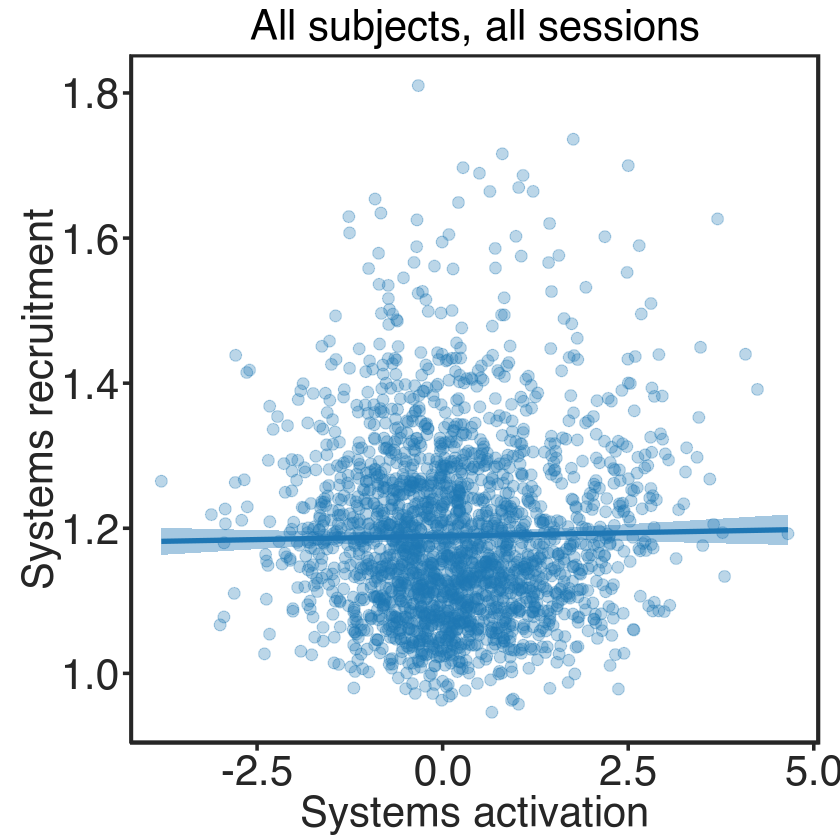

In [114]:
p <- recruitment_activation %>% 
    ggplot(aes(Activation, Recruitment)) +
    geom_point(size = 3, alpha = 0.3, col = '#1f77b4') +
    geom_smooth(method='lm', col = '#1f77b4', fill = '#1f77b4', size = 1.5) +
    theme_training +
    ylab('Systems recruitment') +
    xlab('Systems activation') + 
    ggtitle('All subjects, all sessions')

p

ggsave("figures/activation_recruitment.pdf", plot = p, width = 12, height = 6, dpi = 300)  

### Correlation of brain activiy changes with systems recruiment change (all subjects, Naive --> Late)

In [87]:
cor.test(delta$Recruitment, delta$Activation)


	Pearson's product-moment correlation

data:  delta$Recruitment and delta$Activation
t = -1.4225, df = 544, p-value = 0.1554
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1440537  0.0231533
sample estimates:
       cor 
-0.0608773 


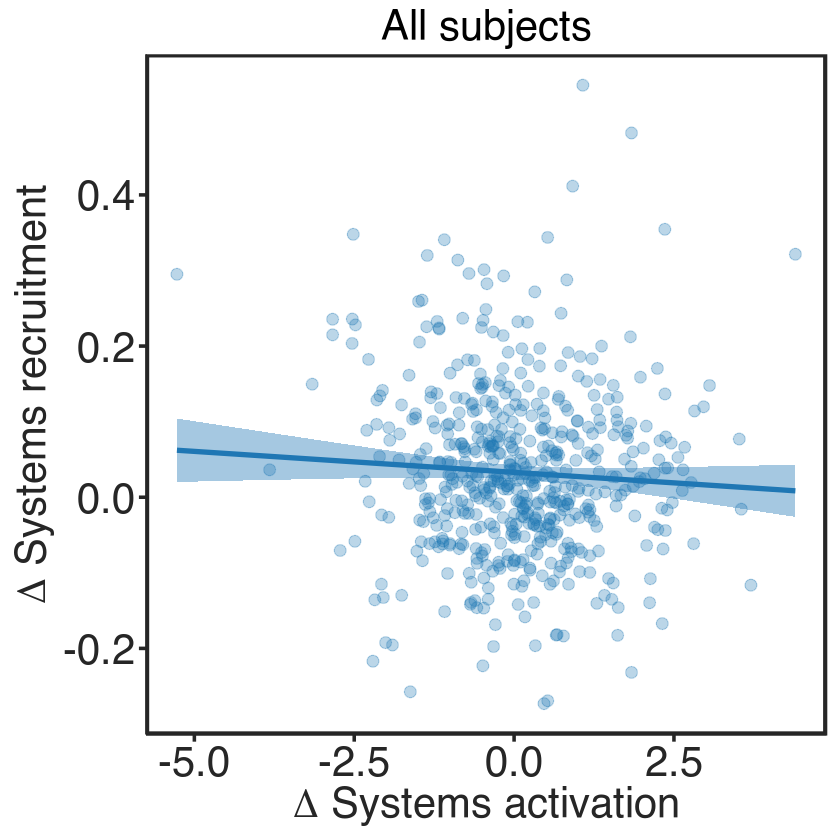

In [113]:
delta <- (recruitment_activation %>% filter(Session=='Late') %>% select(Recruitment, Activation)) - 
         (recruitment_activation%>%filter(Session=='Naive') %>% select(Recruitment, Activation))

p <- delta %>% 
    ggplot(aes(Activation, Recruitment)) +
    geom_point(size = 3, alpha = 0.3, col = '#1f77b4') +
    geom_smooth(method='lm', col = '#1f77b4', fill = '#1f77b4', size = 1.5) +
    theme_training +
    ylab(expression(Delta*' Systems recruitment')) +
    xlab(expression(Delta*' Systems activation')) + 
    ggtitle('All subjects')


p

ggsave("figures/delta_activation_recruitment.pdf", plot = p, width = 12, height = 6, dpi = 300)  

### Correlation of brain activiy changes with systems recruiment change (experimental group, Naive --> Late)

In [102]:
exp <- (recruitment_activation %>% 
        filter(Session=='Late') %>% 
        filter(Group=='Experimental') %>% 
        select(Recruitment, Activation)) - 
         (recruitment_activation %>%
          filter(Group=='Experimental') %>% 
          filter(Session=='Naive') %>% 
          select(Recruitment, Activation))

In [105]:
cor.test(exp$Recruitment, exp$Activation)


	Pearson's product-moment correlation

data:  exp$Recruitment and exp$Activation
t = -1.125, df = 271, p-value = 0.2616
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.18539427  0.05095181
sample estimates:
        cor 
-0.06817771 


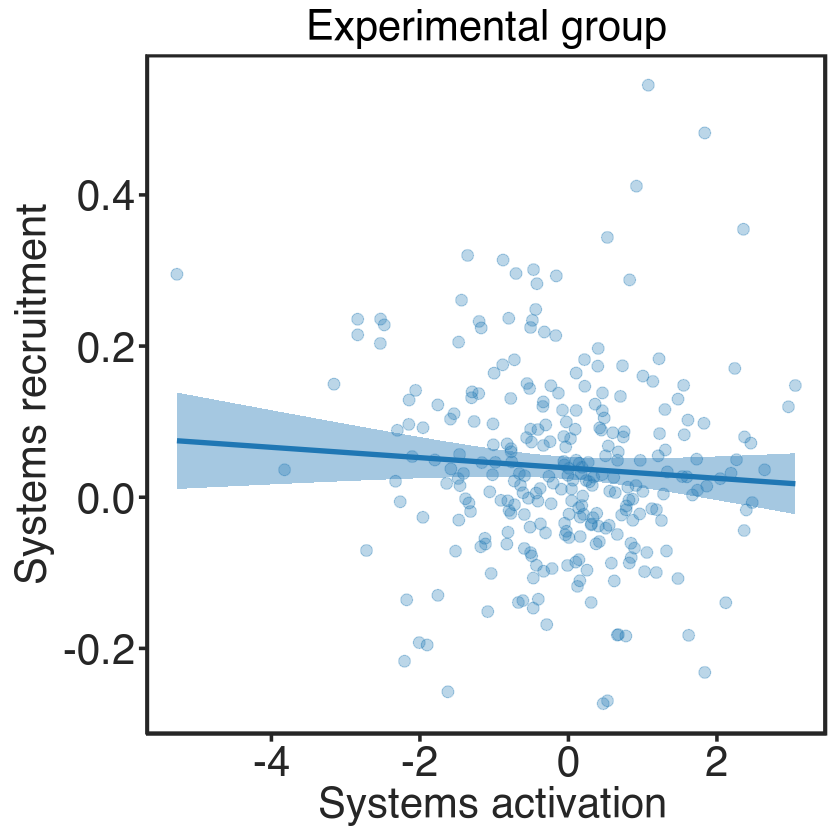

In [110]:
p <- exp%>% 
    ggplot(aes(Activation, Recruitment)) +
    geom_point(size = 3, alpha = 0.3, col = '#1f77b4') +
    geom_smooth(method='lm', col = '#1f77b4', fill = '#1f77b4', size = 1.5) +
    theme_training +
    ylab(expression('Systems recruitment')) +
    xlab(expression(' Systems activation')) +
    ggtitle('Experimental group')

p

ggsave("figures/exp_activation_recruitment.pdf", plot = p, width = 12, height = 6, dpi = 300)  

In [67]:
## Correlation with FP-DM integration
glm_filtered <- glm %>% filter(Group=='Experimental')
network1 <- 'FP'
network2 <- 'DM'

net_naive <- networks_allegiance %>% filter(Network == network1) %>% filter(Session=='Naive') %>% filter(Group=='Experimental')
net_late <- networks_allegiance %>% filter(Network == network1) %>% filter(Session=='Late')%>% filter(Group=='Experimental')
variable <- net_late[[network2]] - net_naive[[network2]]

glm_change <- glm_filtered %>% 
               filter(Network == network2) %>% 
               filter(Session=='Late') %>% 
               select(Activation) - 
               glm_filtered %>% 
               filter(Network == network2) %>% 
               filter(Session=='Naive') %>% 
               select(Activation)

print(cor.test(variable, glm_change[,1]))


	Pearson's product-moment correlation

data:  variable and glm_change[, 1]
t = 1.4349, df = 19, p-value = 0.1676
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1375727  0.6558439
sample estimates:
      cor 
0.3126839 



In [13]:
glm_filtered <- glm 
cor_results <- data.frame()

for (i in 1:length(unique_networks)){
        
        network <- as.character(unique_networks[i])
    
        net_naive <- networks_allegiance %>% filter(Network == network) #%>% filter(Session=='Naive') 
        variable <- net_naive[[network]] 
    
        glm_change <-  glm_filtered %>% filter(Network == network) %>% 
                       #filter(Session=='Naive') %>% 
                       select(Activation)
         correlation <- cor.test(variable, glm_change[,1])
         cor <- c(i, correlation$estimate, correlation$p.value)
         cor_results <- rbind(cor_results, cor)
         names(cor_results) <- c('i', 'r', 'pval') 
}

cor_results$p_fdr <- p.adjust(cor_results$pval, method='fdr')
cor_results$network <- unique_networks[cor_results$i]

Activation
-1.16410401
0.83787982
0.00663751
0.77337313
-0.33644235
-1.90236538
0.71142897
-1.23820994
1.00296767
-1.03531551
